In [1]:
#@title Global Settings
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.datasets
from tensorflow.keras import regularizers

import os

import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [13]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'MosMedData'

In [2]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [ ]:
!conda install -c conda-forge nibabel

^C


In [5]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [31]:
## Read and process the scans.
## Each scan is resized across height, width, and depth and rescaled.
#abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
#normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
#
## For the CT scans having presence of viral pneumonia
## assign 1, for the normal ones assign 0.
#abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
#normal_labels = np.array([0 for _ in range(len(normal_scans))])
#
## Split data in the ratio 70-30 for training and validation.
#X_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
#y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
#X_val = np.concatenate((abnormal_scans[70:90], normal_scans[70:90]), axis=0)
#y_val = np.concatenate((abnormal_labels[70:90], normal_labels[70:90]), axis=0)
#X_test = np.concatenate((abnormal_scans[90:], normal_scans[90:]), axis=0)
#y_test = np.concatenate((abnormal_labels[90:], normal_labels[90:]), axis=0)
#print("Number of samples in train and validation are %d and %d." % (X_train.shape[0], X_val.shape[0]))

Number of samples in train and validation are 140 and 40.


In [ ]:
c = np.fromfile('test2.dat', dtype=int)

In [46]:
#np.save('Xtrain', X_train)
#np.save('ytrain', y_train)
#np.save('Xval',   X_val)
#np.save('yval',   y_val)
#np.save('Xtest',  X_test)
#np.save('ytest',  y_test)
#
X_train1 = np.load('Xtrain.npy')
y_train1 = np.load('ytrain.npy')
X_val1   = np.load('Xval.npy'  )
y_val1   = np.load('yval.npy'  )
X_test1  = np.load('Xtest.npy' )
y_test1  = np.load('ytest.npy' )

In [62]:
y_train.shape

(140,)

In [13]:

#dataset=tensorflow.keras.datasets.cifar10 #@param ["tensorflow.keras.datasets.cifar10", "tensorflow.keras.datasets.cifar100", "tensorflow.keras.datasets.mnist", "tensorflow.keras.datasets.fashion_mnist"] {type:"raw"} 
batch_size=64 # @param [16, 32, 64, 128, 256, 512] {type:"raw"} 
channels_per_group=32 # @param [2, 4, 8, 12, 16, 32] {type:"raw"}
epochs=50 # @param [2, 25, 50, 75, 100, 100, 200, 400] {type:"raw"}
verbose=True #@param {type:"boolean"}
bipolar_input=True #@param {type:"boolean"}
seed=7

global_input_shape = (128, 128, 64, 1)

num_classes = 2

In [14]:
import cai.layers
import cai.datasets
import cai.efficientnet
import cai.util
import gc
import multiprocessing
import random
import tensorflow as tf
import numpy as np
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.12.0
Keras version: 2.12.0
CPU cores: 8
RAM: 16.859602944 GB
[]


In [26]:
if channels_per_group==2:
   kTypes = [cai.layers.D6v3_2ch()]
elif channels_per_group==4:
   kTypes = [cai.layers.D6v3_4ch()]
elif channels_per_group==8:
   kTypes = [cai.layers.D6v3_8ch()]
elif channels_per_group==12:
   kTypes = [cai.layers.D6v3_12ch()]
elif channels_per_group==16:
   kTypes = [cai.layers.D6v3_16ch()]
else:
   kTypes = [cai.layers.D6v3_32ch()]

In [48]:
base_model_name='kEffNet3DV2_test'

#x_train, y_train, x_val, y_val, x_test, y_test = cai.datasets.load_dataset_with_validation(dataset,
#  lab=False, verbose=verbose, bipolar=bipolar_input,
#  base_model_name=base_model_name,
#  validation_size=0.1, validation_flip_horizontal=True,
#  validation_flip_vertical=False)

print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

Train shapes: (140, 128, 128, 64) (140,)
Validation shapes: (40, 128, 128, 64) (40,)
Test shapes: (20, 128, 128, 64) (20,)


In [49]:
X_val   =   X_val1.reshape(40, 128, 128, 64, 1)  
X_test  =  X_test1.reshape(20, 128, 128, 64, 1)
X_train = X_train1.reshape(140, 128, 128, 64, 1)

In [19]:
from kEffNet3D import kEfficientNet3DB0

In [53]:
base_model_name='kEffNet3DV2'

train_datagen = cai.util.create_image_generator(rotation_range=20, 
  width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0)
valid_datagen = cai.util.create_image_generator_no_augmentation()
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [69]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [70]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [71]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [84]:
y_train2 = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test2 = np.asarray(y_test).astype('float32').reshape((-1,1))
y_val2 = np.asarray(y_val1).astype('float32').reshape((-1,1))

In [99]:
y_train3 = to_categorical(y_train1,2)
y_val3 = to_categorical(y_val1, 2)
y_test3 = to_categorical(y_test1, 2)

In [92]:
from tensorflow.keras.utils import to_categorical

In [83]:
y_train.shape, y_train2.shape

((140,), (140, 1))

In [100]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train1, y_train3))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val1, y_val3))
test_loader = tf.data.Dataset.from_tensor_slices((X_test1, y_test3))


batch_size = 32
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train1))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(X_val1))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

test_dataset = (
    validation_loader.shuffle(len(X_test1))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


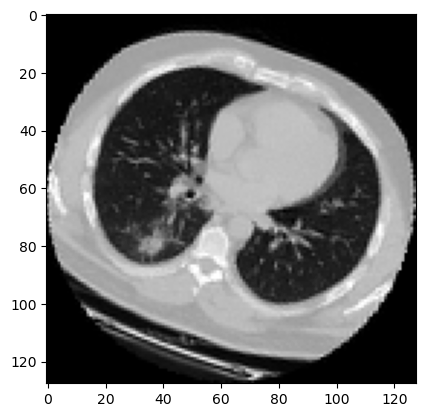

In [86]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [101]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False, kTypes=[]):
  monitor='val_loss'
  if (show_model):
    input_shape = global_input_shape
  else:
    input_shape = (None, None, None, global_input_shape[3])
  for kType in kTypes:
      basefilename = 'kEffNetV2-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      model = kEfficientNet3DB0(
        include_top=True,
        skip_stride_cnt=3,
        input_shape=input_shape,
        classes=num_classes,
        kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary(line_length=180)

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit):
            history = model.fit(
              train_dataset,
              validation_data=validation_dataset,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            X_test1, y_test1, 
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      #if (calc_f1):
      #  cai.datasets.test_flips_on_saved_model(X_test1, y_test1, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=False, center_crop=0.15)
      print('Finished: '+basefilename)

In [102]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=False, kTypes=kTypes)

Running: kEffNetV2-33
before ZeroPadding3D KerasTensor(type_spec=TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name='input_14'), name='input_14', description="created by layer 'input_14'")
(None, None, None) channels_last
after ZeroPadding3D KerasTensor(type_spec=TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None), name='k_stem_conv_pad3d/Pad:0', description="created by layer 'k_stem_conv_pad3d'")
x = kblock before     KerasTensor(type_spec=TensorSpec(shape=(None, None, None, None, 32), dtype=tf.float32, name=None), name='k_stem_activation3d/mul:0', description="created by layer 'k_stem_activation3d'")
aaaaaaaaaaaaaaa
kPointwiseConv3D 1v se =  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 1, 32), dtype=tf.float32, name=None), name='k_block1a__0se_reshape/Reshape:0', description="created by layer 'k_block1a__0se_reshape'")
last tensor input kPointwiseConv3D    KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 1, 32), dtype=tf.float32, nam